In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
import folium
import geopandas as gpd
import folium
from folium.plugins import HeatMapWithTime
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import itertools
from folium.plugins import MarkerCluster
import re
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from matplotlib.animation import FuncAnimation
from scipy.stats import gaussian_kde
import time
from shapely.geometry import Point
import contextily as ctx
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
# kmeans_spatial_clustering.py

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import json

# Load the data
df = pd.read_csv("Time_formatted_fixed_loc.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df[['Datetime', 'LAT', 'LON']].dropna()

# Standardize LAT and LON
scaler = StandardScaler()
df[['LAT_std', 'LON_std']] = scaler.fit_transform(df[['LAT', 'LON']])

# KMeans on standardized coordinates
kmeans = KMeans(n_clusters=30, random_state=42)
df['Hotspot'] = kmeans.fit_predict(df[['LAT_std', 'LON_std']])

# Load LA boundary GeoJSON
with open("la_boundary.geojson", "r") as f:
    la_boundary = json.load(f)

# Visualize using original coordinates
fig = px.scatter_mapbox(
    df.sample(frac=0.05, random_state=42),
    lat="LAT",
    lon="LON",
    color="Hotspot",
    zoom=9.5,
    center={"lat": 34.05, "lon": -118.25},
    height=800
)

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_layers=[
        {"source": la_boundary, "type": "line", "color": "red"},
    ],
    margin={"r": 0, "t": 0, "l": 0, "b": 0}
)

fig.show()


# Kmeans Clustering 30

In [3]:
df['Hotspot'].value_counts()

Hotspot
0     34425
17    30484
12    20168
21    16689
9     16572
26    16187
29    15879
14    14758
20    14127
10    12388
23    11637
18    11240
5      9920
4      9823
15     9642
2      9617
3      9463
1      8418
19     8392
7      7661
13     7198
22     6967
27     6266
8      5493
24     5439
25     4912
6      4590
11     3962
16     1491
28      748
Name: count, dtype: int64

In [4]:
import pandas as pd

# Step 1: Ensure 'Date' column is daily
df['Date'] = df['Datetime'].dt.floor('D')  # or .dt.date if you prefer date objects

# Step 2: Group by 'Date' and 'Hotspot' and count occurrences
time_series = df.groupby(['Date', 'Hotspot']).size().reset_index(name='CrimeCount')

# Step 3: Pivot the table to have 'Date' as index and 'Hotspot' as columns
ts_pivot = time_series.pivot(index='Date', columns='Hotspot', values='CrimeCount').fillna(0)

# Step 4: Sort the index to ensure chronological order
ts_pivot = ts_pivot.sort_index()

# Step 5: Reindex to ensure every day is present (fill gaps with 0)
full_index = pd.date_range(start=ts_pivot.index.min(), end=ts_pivot.index.max(), freq='D')
ts_pivot = ts_pivot.reindex(full_index, fill_value=0)

# Step 6: Set the proper index name (optional, but good practice)
ts_pivot.index.name = 'Date'

# Now, ts_pivot is your complete daily time series!
print(ts_pivot.head())


Hotspot       0     1     2    3    4     5     6    7    8     9   ...    20  \
Date                                                                ...         
2020-01-01  17.0   2.0   4.0  4.0  7.0   2.0   1.0  4.0  4.0  16.0  ...  10.0   
2020-01-02  23.0   3.0   6.0  2.0  8.0   9.0  14.0  4.0  1.0   8.0  ...   5.0   
2020-01-03  11.0  10.0  12.0  8.0  8.0  20.0   6.0  2.0  1.0  26.0  ...  15.0   
2020-01-04  20.0   5.0   4.0  9.0  7.0   2.0   4.0  1.0  4.0  30.0  ...   7.0   
2020-01-05  23.0   3.0   2.0  3.0  9.0   4.0   1.0  3.0  2.0   8.0  ...  12.0   

Hotspot       21    22    23   24   25    26   27   28    29  
Date                                                          
2020-01-01  12.0   4.0  10.0  3.0  2.0   9.0  3.0  0.0  13.0  
2020-01-02   6.0  11.0  10.0  0.0  3.0  15.0  2.0  0.0  12.0  
2020-01-03  13.0   8.0   1.0  5.0  7.0   7.0  5.0  0.0  13.0  
2020-01-04  19.0   1.0   8.0  1.0  5.0   6.0  4.0  0.0  10.0  
2020-01-05   5.0   2.0   5.0  4.0  7.0  15.0  4.0  0.0

In [5]:
ts_pivot

Hotspot       0     1     2    3    4     5     6    7    8     9   ...    20  \
Date                                                                ...         
2020-01-01  17.0   2.0   4.0  4.0  7.0   2.0   1.0  4.0  4.0  16.0  ...  10.0   
2020-01-02  23.0   3.0   6.0  2.0  8.0   9.0  14.0  4.0  1.0   8.0  ...   5.0   
2020-01-03  11.0  10.0  12.0  8.0  8.0  20.0   6.0  2.0  1.0  26.0  ...  15.0   
2020-01-04  20.0   5.0   4.0  9.0  7.0   2.0   4.0  1.0  4.0  30.0  ...   7.0   
2020-01-05  23.0   3.0   2.0  3.0  9.0   4.0   1.0  3.0  2.0   8.0  ...  12.0   
...          ...   ...   ...  ...  ...   ...   ...  ...  ...   ...  ...   ...   
2025-01-28   9.0   4.0   3.0  4.0  4.0   1.0   4.0  2.0  5.0   8.0  ...   6.0   
2025-01-29  11.0   3.0   4.0  0.0  8.0   3.0   0.0  2.0  2.0   9.0  ...   6.0   
2025-01-30  10.0   1.0   5.0  8.0  7.0   2.0   3.0  3.0  0.0   7.0  ...   3.0   
2025-01-31   5.0   4.0  12.0  3.0  1.0   3.0   3.0  1.0  2.0   3.0  ...   8.0   
2025-02-01   8.0   1.0   5.0  7.0  1.0   1.0   2.0  5.0  0.0   9.0  ...  10.0   

Hotspot       21    22    23   24   25    26   27   28    29  
Date                                                          
2020-01-01  12.0   4.0  10.0  3.0  2.0   9.0  3.0  0.0  13.0  
2020-01-02   6.0  11.0  10.0  0.0  3.0  15.0  2.0  0.0  12.0  
2020-01-03  13.0   8.0   1.0  5.0  7.0   7.0  5.0  0.0  13.0  
2020-01-04  19.0   1.0   8.0  1.0  5.0   6.0  4.0  0.0  10.0  
2020-01-05   5.0   2.0   5.0  4.0  7.0  15.0  4.0  0.0   7.0  
...          ...   ...   ...  ...  ...   ...  ...  ...   ...  
2025-01-28   6.0   1.0   3.0  2.0  2.0   8.0  4.0  1.0   8.0  
2025-01-29   4.0   2.0   6.0  2.0  2.0   8.0  3.0  2.0   5.0  
2025-01-30   5.0   1.0   3.0  3.0  4.0  14.0  3.0  0.0   7.0  
2025-01-31   5.0   1.0   2.0  2.0  2.0   9.0  3.0  0.0   5.0  
2025-02-01   7.0   2.0   1.0  3.0  3.0   3.0  0.0  0.0   6.0  

[1859 rows x 30 columns]

### Timeseries Plot 

In [6]:
ts_pivot.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1859 entries, 2020-01-01 to 2025-02-01
Freq: D
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1859 non-null   float64
 1   1       1859 non-null   float64
 2   2       1859 non-null   float64
 3   3       1859 non-null   float64
 4   4       1859 non-null   float64
 5   5       1859 non-null   float64
 6   6       1859 non-null   float64
 7   7       1859 non-null   float64
 8   8       1859 non-null   float64
 9   9       1859 non-null   float64
 10  10      1859 non-null   float64
 11  11      1859 non-null   float64
 12  12      1859 non-null   float64
 13  13      1859 non-null   float64
 14  14      1859 non-null   float64
 15  15      1859 non-null   float64
 16  16      1859 non-null   float64
 17  17      1859 non-null   float64
 18  18      1859 non-null   float64
 19  19      1859 non-null   float64
 20  20      1859 non-null   float64
 21  21      185

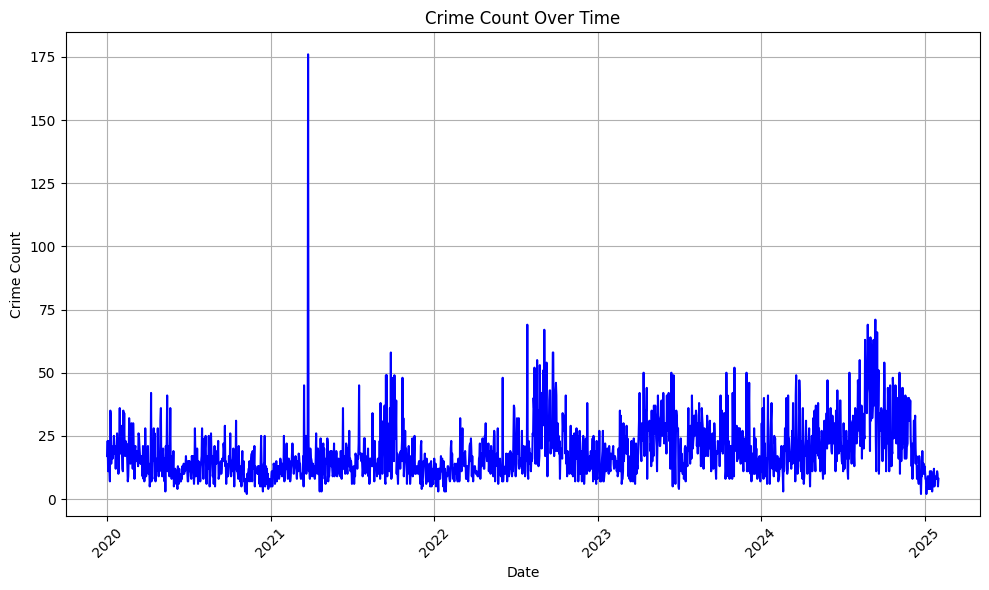

In [7]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(ts_pivot[0].index, ts_pivot[0], label='Crime Count', color='b')
plt.title('Crime Count Over Time')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### ACF Plot

<Figure size 1000x500 with 0 Axes>

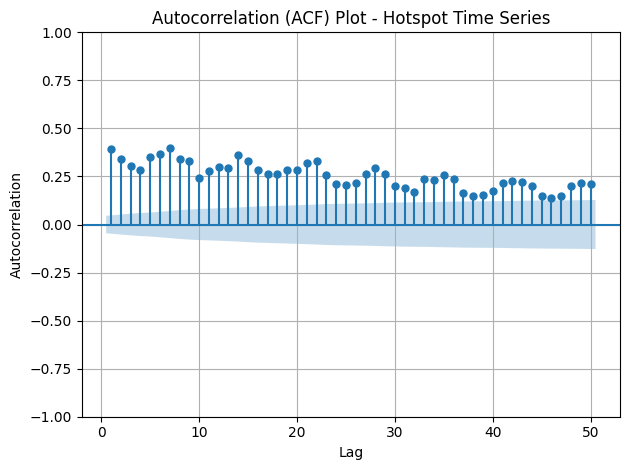

In [8]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

hotspot_series = ts_pivot[0].values

plt.figure(figsize=(10, 5))
plot_acf(hotspot_series, lags=50, zero=False)
plt.title("Autocorrelation (ACF) Plot - Hotspot Time Series")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.tight_layout()
plt.show()

### ADF Test

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

# --- Suppress warnings and logs ---
warnings.filterwarnings("ignore")

# === Load Time Series Data ===
# Example: ts_pivot should be a DataFrame with datetime index and hotspot series as columns
# You should replace this with actual loading logic
# ts_pivot = pd.read_csv("your_timeseries.csv", index_col=0, parse_dates=True)
hotspot_series = ts_pivot[0].values
dates = ts_pivot.index

# === Train-Test Split (90/10) ===
split_idx = int(len(hotspot_series) * 0.9)
train_data = hotspot_series[:split_idx]
test_data = hotspot_series[split_idx:]
test_dates = dates[split_idx:]

# === 1. ADF Test ===
print("== ADF Stationarity Test ==")
adf_result = adfuller(train_data)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("=> Stationary" if adf_result[1] < 0.05 else "=> Non-Stationary")

== ADF Stationarity Test ==
ADF Statistic: -3.5098
p-value: 0.0077
=> Stationary


### Data Preprocessing

# Models

### Auto Regression

In [10]:
import numpy as np
import warnings
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# --- Preprocessing ---
hotspot_series = ts_pivot[0].values.reshape(-1, 1)

# Normalize the data to scale it between 0 and 1
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series).flatten()

# --- Train/test split (80/20) ---
split_idx = int(len(hotspot_scaled) * 0.8)
train_data, test_data = hotspot_scaled[:split_idx], hotspot_scaled[split_idx:]

# --- Inverse transform helper ---
def inverse_transform(y_scaled):
    return scaler.inverse_transform(np.array(y_scaled).reshape(-1, 1)).flatten()

# Suppress all warnings
warnings.filterwarnings('ignore')

print(f"hotspot_scaled shape: {hotspot_scaled.shape}")
print(f"Test data shape: {test_data.shape}")

best_ar_rmse = float('inf')
best_ar_lag = None
best_ar_actual = None
best_ar_pred = None

# --- AutoRegressive Model ---
for lag in range(1, 40):
    if len(train_data) <= lag:
        print(f"Skipping lag {lag} due to insufficient training data.")
        continue

    try:
        # Fit model on training data
        model_ar = AutoReg(train_data, lags=lag, old_names=False).fit()

        # Forecast for the test period
        pred_ar_scaled = model_ar.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

        # Inverse transform
        pred_ar = inverse_transform(pred_ar_scaled)
        actual_ar = inverse_transform(test_data)

        # Evaluate
        rmse = np.sqrt(mean_squared_error(actual_ar, pred_ar))
        if rmse < best_ar_rmse:
            best_ar_rmse = rmse
            best_ar_lag = lag
            best_ar_pred = pred_ar
            best_ar_actual = actual_ar
    except Exception as e:
        print(f"Error for lag {lag}: {e}")
        continue

# --- Output Results ---
if best_ar_lag is not None:
    print(f"Best AR Lag: {best_ar_lag}")
    print(f"AR RMSE: {best_ar_rmse:.2f}")
    print(f"AR MAPE: {mean_absolute_percentage_error(best_ar_actual, best_ar_pred) * 100:.2f}%")
else:
    print("No valid AR model was found.")


hotspot_scaled shape: (1859,)
Test data shape: (372,)
Best AR Lag: 28
AR RMSE: 14.48
AR MAPE: 56.52%


### SARIMA

In [12]:
import warnings
import itertools
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

# --- Preprocessing ---
hotspot_series = ts_pivot[0].values.reshape(-1, 1)

# Normalize the data to scale it between 0 and 1
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series).flatten()

# --- Train/test split (80/20) ---
split_idx = int(len(hotspot_scaled) * 0.8)
train_data, test_data = hotspot_scaled[:split_idx], hotspot_scaled[split_idx:]

# --- Inverse transform helper ---
def inverse_transform(y_scaled):
    return scaler.inverse_transform(np.array(y_scaled).reshape(-1, 1)).flatten()

# Suppress all warnings
warnings.filterwarnings('ignore')

# --- Define parameter ranges for SARIMA ---
p = d = q = range(0, 3)  # Non-seasonal params
P = D = Q = range(0, 2)  # Seasonal params
s = 12  # Seasonal period (adjust if needed)

best_sarima_rmse = float('inf')
best_seasonal_order = None
best_order_sarima = None
best_sarima_pred = None
best_sarima_actual = None

# --- SARIMA Grid Search ---
for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q):
        try:
            # Fit SARIMA model on training data
            model_sarima = SARIMAX(train_data,
                                   order=order,
                                   seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False).fit(disp=False)

            # Forecast for test data length
            pred_sarima_scaled = model_sarima.forecast(steps=len(test_data))

            # Inverse transform
            pred_sarima = inverse_transform(pred_sarima_scaled)
            actual_sarima = inverse_transform(test_data)

            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(actual_sarima, pred_sarima))

            # Update best model
            if rmse < best_sarima_rmse:
                best_sarima_rmse = rmse
                best_order_sarima = order
                best_seasonal_order = seasonal_order
                best_sarima_pred = pred_sarima
                best_sarima_actual = actual_sarima
        except Exception as e:
            print(f"Error for order {order} seasonal {seasonal_order}: {e}")
            continue

# --- Output Best SARIMA Model ---
if best_order_sarima is not None:
    print(f"Best SARIMA Order: {best_order_sarima}, Seasonal: {best_seasonal_order} x {s}")
    print(f"SARIMA RMSE: {best_sarima_rmse:.2f}")
    print(f"SARIMA MAPE: {mean_absolute_percentage_error(best_sarima_actual, best_sarima_pred) * 100:.2f}%")
else:
    print("No valid SARIMA model was found.")


Best SARIMA Order: (1, 1, 0), Seasonal: (0, 0, 0) x 12
SARIMA RMSE: 13.19
SARIMA MAPE: 73.56%


### SARIMA with Karimann filtering


For lag = 1
Test RMSE: 12.9095
MAPE: 43.53%

For lag = 2
Test RMSE: 11.7794
MAPE: 43.01%

For lag = 3
Test RMSE: 11.3598
MAPE: 43.25%

For lag = 4
Test RMSE: 11.1813
MAPE: 43.78%

For lag = 6
Test RMSE: 10.7060
MAPE: 43.51%

For lag = 9
Test RMSE: 10.4314
MAPE: 43.89%

For lag = 12
Test RMSE: 10.3948
MAPE: 43.82%

For lag = 16
Test RMSE: 10.2496
MAPE: 44.73%

For lag = 24
Test RMSE: 10.1885
MAPE: 44.74%

For lag = 30
Test RMSE: 10.2144
MAPE: 45.42%

For lag = 40
Test RMSE: 10.1743
MAPE: 45.36%

For lag = 50
Test RMSE: 10.2095
MAPE: 46.11%


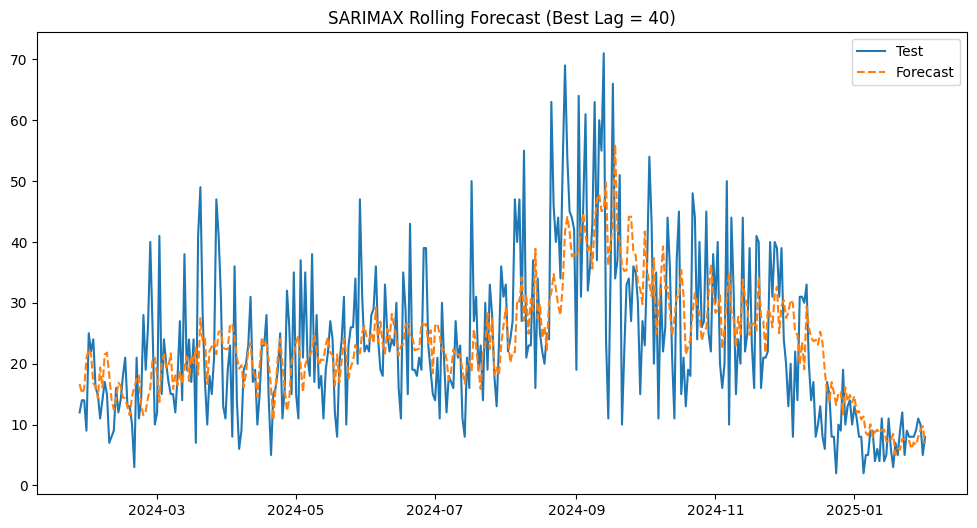

In [13]:
# ================== Cell 6: SARIMA Forecasting with Lag Optimization ==================
import torch.nn as nn
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

series = ts_pivot[0].astype(float).dropna()  # Example hotspot 0

lag_arr = [1, 2, 3, 4, 6, 9, 12, 16, 24, 30, 40, 50]

best_rmse = float('inf')
best_result = {}

for lag in lag_arr:
    train_size = int(len(series) * 0.8)
    train, test = series.iloc[:train_size], series.iloc[train_size:]

    # Ensure correct data types and index
    train = pd.Series(train.values, index=train.index, dtype='float')
    test = pd.Series(test.values, index=test.index, dtype='float')

    model = SARIMAX(
        train,
        order=(lag, 0, 0),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    # Append test to Kalman filter
    res_ext = res.append(test)

    # One-step-ahead prediction
    pred = res_ext.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
    y_pred = pred.predicted_mean

    if len(y_pred) == len(test):
        # Evaluate
        rmse = np.sqrt(mean_squared_error(test, y_pred))
        mape = mean_absolute_percentage_error(test, y_pred)
        print(f"\nFor lag = {lag}")
        print(f"Test RMSE: {rmse:.4f}")
        print(f"MAPE: {mape * 100:.2f}%")

        if rmse < best_rmse:
            best_rmse = rmse
            best_result = {
                "lag": lag,
                "test": test,
                "y_pred": y_pred
            }

# Optional: plot best forecast
if best_result:
    plt.figure(figsize=(12, 6))
    plt.plot(best_result["test"].index, best_result["test"], label="Test")
    plt.plot(best_result["y_pred"].index, best_result["y_pred"], label="Forecast", linestyle="--")
    plt.legend()
    plt.title(f"SARIMAX Rolling Forecast (Best Lag = {best_result['lag']})")
    plt.show()


###

### LSTM 

Epoch 1, Loss: 0.0426
Epoch 2, Loss: 0.0402
Epoch 3, Loss: 0.0392
Epoch 4, Loss: 0.0394
Epoch 5, Loss: 0.0383
Epoch 6, Loss: 0.0363
Epoch 7, Loss: 0.0385
Epoch 8, Loss: 0.0378
Epoch 9, Loss: 0.0363
Epoch 10, Loss: 0.0365
Epoch 11, Loss: 0.0358
Epoch 12, Loss: 0.0369
Epoch 13, Loss: 0.0363
Epoch 14, Loss: 0.0362
Epoch 15, Loss: 0.0368
Epoch 16, Loss: 0.0359
Epoch 17, Loss: 0.0363
Epoch 18, Loss: 0.0353
Epoch 19, Loss: 0.0356
Epoch 20, Loss: 0.0365
Epoch 21, Loss: 0.0360
Epoch 22, Loss: 0.0360
Epoch 23, Loss: 0.0359
Epoch 24, Loss: 0.0358
Epoch 25, Loss: 0.0350
Epoch 26, Loss: 0.0351
Epoch 27, Loss: 0.0360
Epoch 28, Loss: 0.0357
Epoch 29, Loss: 0.0353
Epoch 30, Loss: 0.0359
Epoch 31, Loss: 0.0354
Epoch 32, Loss: 0.0352
Epoch 33, Loss: 0.0356
Epoch 34, Loss: 0.0353
Epoch 35, Loss: 0.0351
Epoch 36, Loss: 0.0357
Epoch 37, Loss: 0.0356
Epoch 38, Loss: 0.0357
Epoch 39, Loss: 0.0356
Epoch 40, Loss: 0.0354
Epoch 41, Loss: 0.0352
Epoch 42, Loss: 0.0348
Epoch 43, Loss: 0.0360
Epoch 44, Loss: 0.03

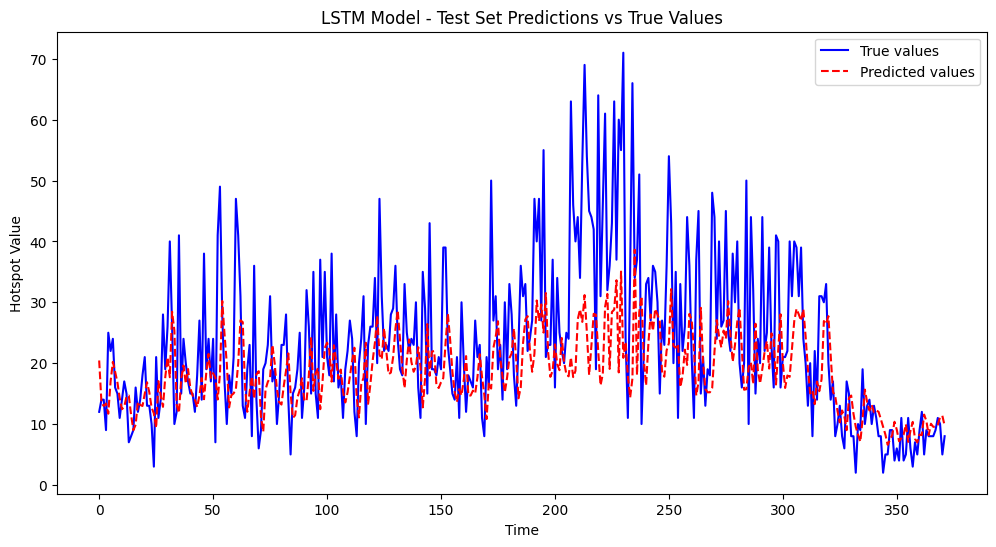

Test RMSE: 12.6568
Test MAPE: 41.49%


In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Assuming ts_pivot is a pandas DataFrame with time series data
hotspot_series = ts_pivot[0].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# Prepare sequences (7 weeks in → 1 week out)
def create_sequences(data, seq_len=2):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

# Create sequences for input features and labels
X, y = create_sequences(hotspot_scaled)

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert the data to tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# Create DataLoader for the training set
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=4, batch_first=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.relu(out[:, -1, :])
        return self.fc(out)

# Initialize model, loss function, and optimizer
model = LSTMModel()
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
model.train()
for epoch in range(200):
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# After training, evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = loss_fn(y_pred, y_test_tensor)
    print(f"Test Loss (L1): {test_loss.item():.4f}")

# Inverse transform to get the predictions in the original scale
y_test_original = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

# Plot the predictions vs true values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="True values", color='blue')
plt.plot(y_pred_original, label="Predicted values", color='red', linestyle='--')
plt.title("LSTM Model - Test Set Predictions vs True Values")
plt.xlabel("Time")
plt.ylabel("Hotspot Value")
plt.legend()
plt.show()

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAPE: {mape * 100:.2f}%")


In [8]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# --- Prepare lag features ---
def create_lag_features(series, n_lags=36):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Use raw values
hotspot_series = ts_pivot[0].values.flatten()

# Create lagged features
n_lags = 12  # Use previous 12 time steps to predict next
X, y = create_lag_features(hotspot_series, n_lags=n_lags)

# Train/Test Split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- XGBoost Regressor ---
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Evaluation ---
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost MAPE: {mape:.2f}%")

XGBoost RMSE: 12.02
XGBoost MAPE: 48.61%


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



# For Cluster 17

# Timeseries Plot

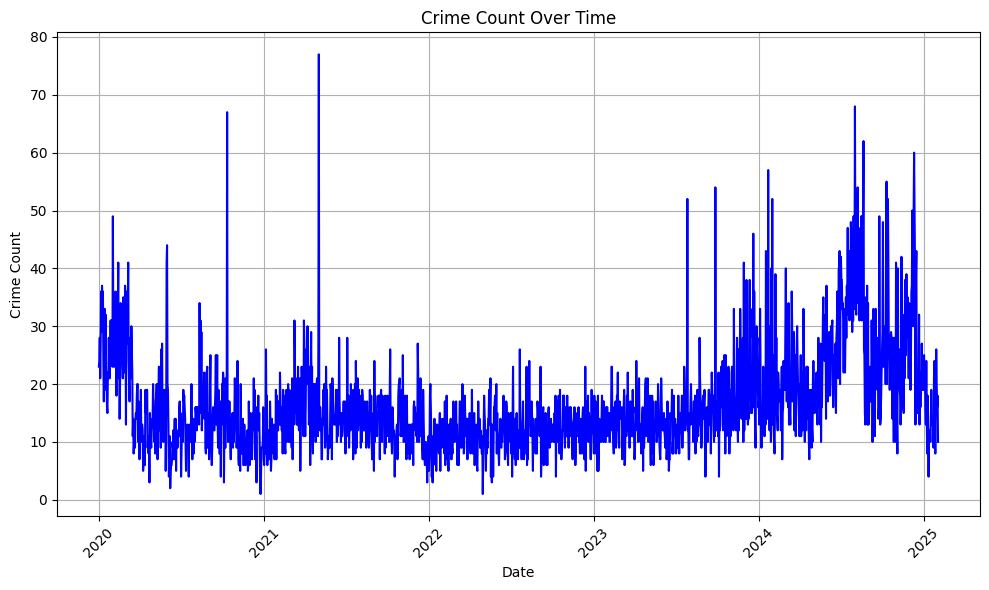

In [18]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(ts_pivot[0].index, ts_pivot[17], label='Crime Count', color='b')
plt.title('Crime Count Over Time')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# ACF Plot

<Figure size 1000x500 with 0 Axes>

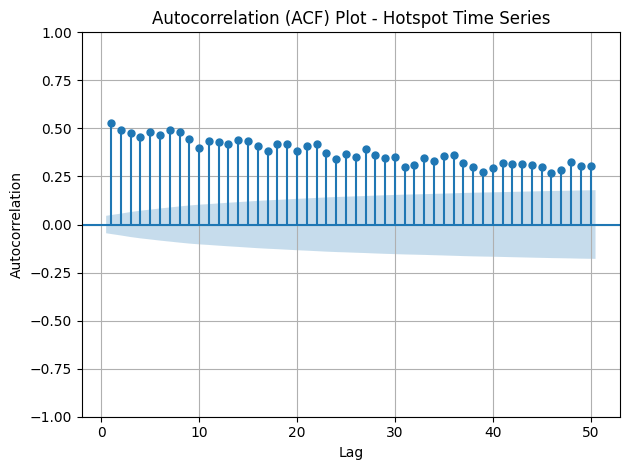

In [20]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

hotspot_series = ts_pivot[17].values

plt.figure(figsize=(10, 5))
plot_acf(hotspot_series, lags=50, zero=False)
plt.title("Autocorrelation (ACF) Plot - Hotspot Time Series")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.tight_layout()
plt.show()

# ATF Test

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

# --- Suppress warnings and logs ---
warnings.filterwarnings("ignore")

# === Load Time Series Data ===
# Example: ts_pivot should be a DataFrame with datetime index and hotspot series as columns
# You should replace this with actual loading logic
# ts_pivot = pd.read_csv("your_timeseries.csv", index_col=0, parse_dates=True)
hotspot_series = ts_pivot[17].values
dates = ts_pivot.index

# === Train-Test Split (90/10) ===
split_idx = int(len(hotspot_series) * 0.9)
train_data = hotspot_series[:split_idx]
test_data = hotspot_series[split_idx:]
test_dates = dates[split_idx:]

# === 1. ADF Test ===
print("== ADF Stationarity Test ==")
adf_result = adfuller(train_data)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("=> Stationary" if adf_result[1] < 0.05 else "=> Non-Stationary")

== ADF Stationarity Test ==
ADF Statistic: -1.4306
p-value: 0.5675
=> Non-Stationary


### Auto Regression

In [22]:
import numpy as np
import warnings
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# --- Preprocessing ---
hotspot_series = ts_pivot[17].values.reshape(-1, 1)

# Normalize the data to scale it between 0 and 1
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series).flatten()

# --- Train/test split (80/20) ---
split_idx = int(len(hotspot_scaled) * 0.8)
train_data, test_data = hotspot_scaled[:split_idx], hotspot_scaled[split_idx:]

# --- Inverse transform helper ---
def inverse_transform(y_scaled):
    return scaler.inverse_transform(np.array(y_scaled).reshape(-1, 1)).flatten()

# Suppress all warnings
warnings.filterwarnings('ignore')

print(f"hotspot_scaled shape: {hotspot_scaled.shape}")
print(f"Test data shape: {test_data.shape}")

best_ar_rmse = float('inf')
best_ar_lag = None
best_ar_actual = None
best_ar_pred = None

# --- AutoRegressive Model ---
for lag in range(1, 40):
    if len(train_data) <= lag:
        print(f"Skipping lag {lag} due to insufficient training data.")
        continue

    try:
        # Fit model on training data
        model_ar = AutoReg(train_data, lags=lag, old_names=False).fit()

        # Forecast for the test period
        pred_ar_scaled = model_ar.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

        # Inverse transform
        pred_ar = inverse_transform(pred_ar_scaled)
        actual_ar = inverse_transform(test_data)

        # Evaluate
        rmse = np.sqrt(mean_squared_error(actual_ar, pred_ar))
        if rmse < best_ar_rmse:
            best_ar_rmse = rmse
            best_ar_lag = lag
            best_ar_pred = pred_ar
            best_ar_actual = actual_ar
    except Exception as e:
        print(f"Error for lag {lag}: {e}")
        continue

# --- Output Results ---
if best_ar_lag is not None:
    print(f"Best AR Lag: {best_ar_lag}")
    print(f"AR RMSE: {best_ar_rmse:.2f}")
    print(f"AR MAPE: {mean_absolute_percentage_error(best_ar_actual, best_ar_pred) * 100:.2f}%")
else:
    print("No valid AR model was found.")


hotspot_scaled shape: (1859,)
Test data shape: (372,)
Best AR Lag: 22
AR RMSE: 14.61
AR MAPE: 38.71%


# SARIMA

In [23]:
import warnings
import itertools
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

# --- Preprocessing ---
hotspot_series = ts_pivot[17].values.reshape(-1, 1)

# Normalize the data to scale it between 0 and 1
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series).flatten()

# --- Train/test split (80/20) ---
split_idx = int(len(hotspot_scaled) * 0.8)
train_data, test_data = hotspot_scaled[:split_idx], hotspot_scaled[split_idx:]

# --- Inverse transform helper ---
def inverse_transform(y_scaled):
    return scaler.inverse_transform(np.array(y_scaled).reshape(-1, 1)).flatten()

# Suppress all warnings
warnings.filterwarnings('ignore')

# --- Define parameter ranges for SARIMA ---
p = d = q = range(0, 3)  # Non-seasonal params
P = D = Q = range(0, 2)  # Seasonal params
s = 12  # Seasonal period (adjust if needed)

best_sarima_rmse = float('inf')
best_seasonal_order = None
best_order_sarima = None
best_sarima_pred = None
best_sarima_actual = None

# --- SARIMA Grid Search ---
for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q):
        try:
            # Fit SARIMA model on training data
            model_sarima = SARIMAX(train_data,
                                   order=order,
                                   seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False).fit(disp=False)

            # Forecast for test data length
            pred_sarima_scaled = model_sarima.forecast(steps=len(test_data))

            # Inverse transform
            pred_sarima = inverse_transform(pred_sarima_scaled)
            actual_sarima = inverse_transform(test_data)

            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(actual_sarima, pred_sarima))

            # Update best model
            if rmse < best_sarima_rmse:
                best_sarima_rmse = rmse
                best_order_sarima = order
                best_seasonal_order = seasonal_order
                best_sarima_pred = pred_sarima
                best_sarima_actual = actual_sarima
        except Exception as e:
            print(f"Error for order {order} seasonal {seasonal_order}: {e}")
            continue

# --- Output Best SARIMA Model ---
if best_order_sarima is not None:
    print(f"Best SARIMA Order: {best_order_sarima}, Seasonal: {best_seasonal_order} x {s}")
    print(f"SARIMA RMSE: {best_sarima_rmse:.2f}")
    print(f"SARIMA MAPE: {mean_absolute_percentage_error(best_sarima_actual, best_sarima_pred) * 100:.2f}%")
else:
    print("No valid SARIMA model was found.")


Best SARIMA Order: (2, 2, 2), Seasonal: (1, 0, 1) x 12
SARIMA RMSE: 10.84
SARIMA MAPE: 43.06%


### SARIMA with Karimann filtering


For lag = 1
Test RMSE: 10.9010
MAPE: 35.66%

For lag = 2
Test RMSE: 9.9602
MAPE: 34.46%

For lag = 3
Test RMSE: 9.4516
MAPE: 33.37%

For lag = 4
Test RMSE: 9.2050
MAPE: 32.74%

For lag = 6
Test RMSE: 9.1490
MAPE: 32.82%

For lag = 9
Test RMSE: 8.9648
MAPE: 32.75%

For lag = 12
Test RMSE: 8.9584
MAPE: 33.17%

For lag = 16
Test RMSE: 8.9968
MAPE: 33.78%

For lag = 24
Test RMSE: 8.9851
MAPE: 34.00%

For lag = 30
Test RMSE: 9.0620
MAPE: 34.74%

For lag = 40
Test RMSE: 9.0836
MAPE: 34.87%

For lag = 50
Test RMSE: 9.0789
MAPE: 34.93%


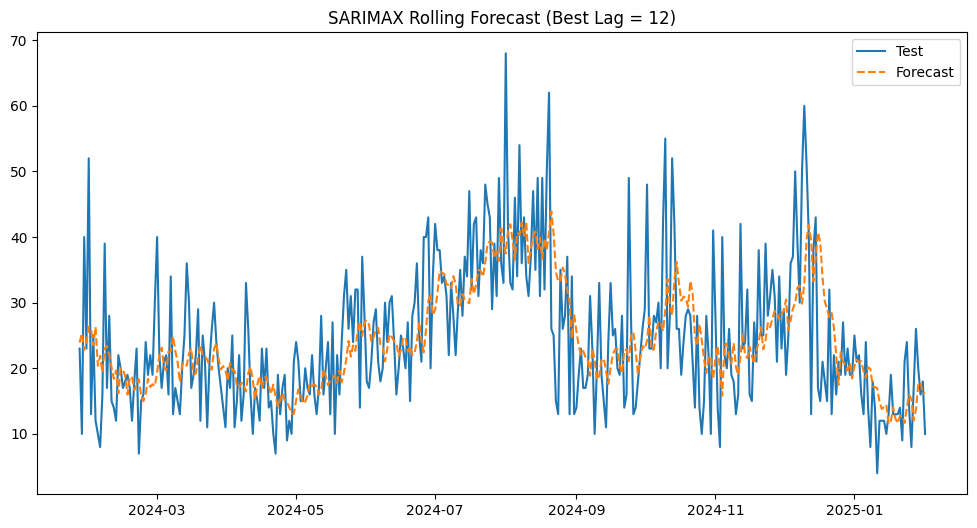

In [24]:
# ================== Cell 6: SARIMA Forecasting with Lag Optimization ==================
import torch.nn as nn
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

series = ts_pivot[17].astype(float).dropna()  # Example hotspot 0

lag_arr = [1, 2, 3, 4, 6, 9, 12, 16, 24, 30, 40, 50]

best_rmse = float('inf')
best_result = {}

for lag in lag_arr:
    train_size = int(len(series) * 0.8)
    train, test = series.iloc[:train_size], series.iloc[train_size:]

    # Ensure correct data types and index
    train = pd.Series(train.values, index=train.index, dtype='float')
    test = pd.Series(test.values, index=test.index, dtype='float')

    model = SARIMAX(
        train,
        order=(lag, 0, 0),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    # Append test to Kalman filter
    res_ext = res.append(test)

    # One-step-ahead prediction
    pred = res_ext.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
    y_pred = pred.predicted_mean

    if len(y_pred) == len(test):
        # Evaluate
        rmse = np.sqrt(mean_squared_error(test, y_pred))
        mape = mean_absolute_percentage_error(test, y_pred)
        print(f"\nFor lag = {lag}")
        print(f"Test RMSE: {rmse:.4f}")
        print(f"MAPE: {mape * 100:.2f}%")

        if rmse < best_rmse:
            best_rmse = rmse
            best_result = {
                "lag": lag,
                "test": test,
                "y_pred": y_pred
            }

# Optional: plot best forecast
if best_result:
    plt.figure(figsize=(12, 6))
    plt.plot(best_result["test"].index, best_result["test"], label="Test")
    plt.plot(best_result["y_pred"].index, best_result["y_pred"], label="Forecast", linestyle="--")
    plt.legend()
    plt.title(f"SARIMAX Rolling Forecast (Best Lag = {best_result['lag']})")
    plt.show()


### LSTM

Epoch 1, Loss: 0.0399
Epoch 2, Loss: 0.0391
Epoch 3, Loss: 0.0393
Epoch 4, Loss: 0.0388
Epoch 5, Loss: 0.0388
Epoch 6, Loss: 0.0393
Epoch 7, Loss: 0.0391
Epoch 8, Loss: 0.0394
Epoch 9, Loss: 0.0388
Epoch 10, Loss: 0.0392
Epoch 11, Loss: 0.0394
Epoch 12, Loss: 0.0391
Epoch 13, Loss: 0.0392
Epoch 14, Loss: 0.0394
Epoch 15, Loss: 0.0389
Epoch 16, Loss: 0.0393
Epoch 17, Loss: 0.0392
Epoch 18, Loss: 0.0392
Epoch 19, Loss: 0.0387
Epoch 20, Loss: 0.0393
Epoch 21, Loss: 0.0389
Epoch 22, Loss: 0.0390
Epoch 23, Loss: 0.0392
Epoch 24, Loss: 0.0391
Epoch 25, Loss: 0.0395
Epoch 26, Loss: 0.0392
Epoch 27, Loss: 0.0388
Epoch 28, Loss: 0.0396
Epoch 29, Loss: 0.0392
Epoch 30, Loss: 0.0389
Epoch 31, Loss: 0.0395
Epoch 32, Loss: 0.0390
Epoch 33, Loss: 0.0393
Epoch 34, Loss: 0.0390
Epoch 35, Loss: 0.0390
Epoch 36, Loss: 0.0389
Epoch 37, Loss: 0.0394
Epoch 38, Loss: 0.0390
Epoch 39, Loss: 0.0392
Epoch 40, Loss: 0.0390
Epoch 41, Loss: 0.0387
Epoch 42, Loss: 0.0396
Epoch 43, Loss: 0.0390
Epoch 44, Loss: 0.03

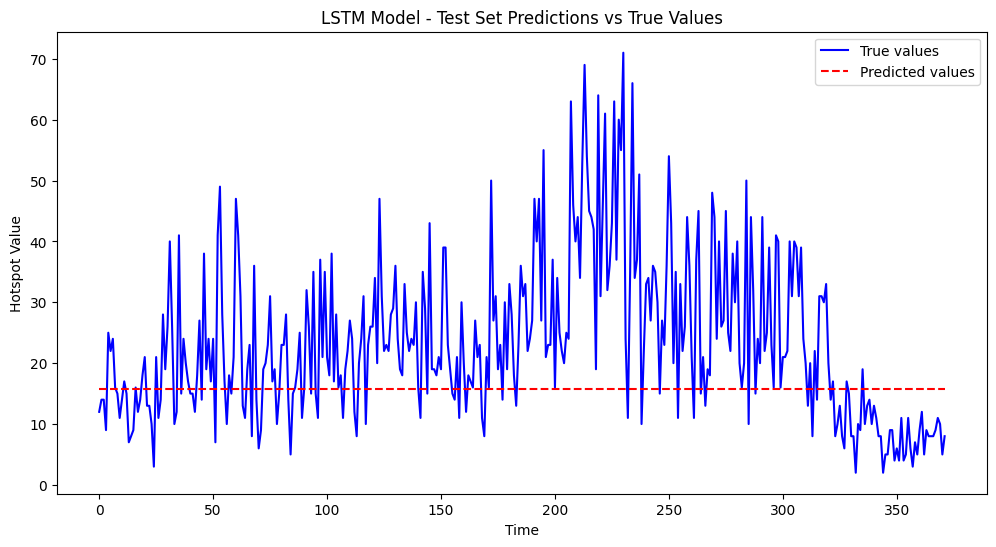

Test RMSE: 15.3141
Test MAPE: 53.20%


In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Assuming ts_pivot is a pandas DataFrame with time series data
hotspot_series = ts_pivot[0].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# Prepare sequences (7 weeks in → 1 week out)
def create_sequences(data, seq_len=2):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

# Create sequences for input features and labels
X, y = create_sequences(hotspot_scaled)

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert the data to tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# Create DataLoader for the training set
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=4, batch_first=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.relu(out[:, -1, :])
        return self.fc(out)

# Initialize model, loss function, and optimizer
model = LSTMModel()
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
model.train()
for epoch in range(200):
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# After training, evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = loss_fn(y_pred, y_test_tensor)
    print(f"Test Loss (L1): {test_loss.item():.4f}")

# Inverse transform to get the predictions in the original scale
y_test_original = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

# Plot the predictions vs true values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="True values", color='blue')
plt.plot(y_pred_original, label="Predicted values", color='red', linestyle='--')
plt.title("LSTM Model - Test Set Predictions vs True Values")
plt.xlabel("Time")
plt.ylabel("Hotspot Value")
plt.legend()
plt.show()

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAPE: {mape * 100:.2f}%")


### xgboost

In [9]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# --- Prepare lag features ---
def create_lag_features(series, n_lags=36):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Use raw values
hotspot_series = ts_pivot[17].values.flatten()

# Create lagged features
n_lags = 12  # Use previous 12 time steps to predict next
X, y = create_lag_features(hotspot_series, n_lags=n_lags)

# Train/Test Split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- XGBoost Regressor ---
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Evaluation ---
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost MAPE: {mape:.2f}%")

XGBoost RMSE: 10.67
XGBoost MAPE: 35.96%


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

